# BitBIRCH with Refinement

This notebook acts as a tutorial for the usage of the new refinement methods available in [BitBIRCH](https://www.biorxiv.org/content/10.1101/2024.08.10.607459v1). (REPLACE WITH PAPER ONCE OUT)

Please reach out to one of the following with any questions or concerns. 

Ramon Alain Miranda Quintana: <ramirandaq@gmail.com>, <quintana@chem.ufl.edu>

Kate Huddleston: <kdavis2@chem.ufl.edu>

Kenneth Lopez Perez: <klopezperez@chem.ufl.edu>
                            

In [ ]:
## Imports 
import numpy as np
from rdkit import Chem
import bitbirch.plotting_utils as plotting_utils
import bitbirch.bitbirch as bb

## Setting up our data

First let's take our SMILES strings and compute our molecular fingerprints. With BitBIRCH, it is **REQUIRED** that the molecular representations are binary fingerprints of dtype int64. 

Below we are reading the .smi file and outputting some np.array of SMILES strings. 

In [2]:
with open('../../data/chembl_33_np.smi', 'r') as f:
    smiles = np.array(f.readlines())
print("Number of smiles: ", smiles.shape[0])

Number of smiles:  64086


We then use [RDKIT](https://github.com/rdkit/rdkit) to generate our binary fingerprints.

In [77]:
mols = [Chem.MolFromSmiles(S) for S in smiles]
fps = np.array([Chem.RDKFingerprint(mol) for mol in mols])  

Now let's check the quality of the generated fingerprints. As stated about we need them to be binary of dtype int64. 

In [9]:
print("Number of fingerprints: ", fps.shape[0])
is_binary = np.all(np.isin(fps, [0, 1]))
is_int64 = fps.dtype == np.int64

assert fps.shape[0] == smiles.shape[0]

if is_binary:
    print("All are binary.")
else:
    print("Some non-binary values.")

if is_int64:
    print("All are int64.")
else:
    print("Some are not int64.")
    


Number of fingerprints:  64086
All are binary.
Some are not int64.


## Refinement

Now we will take you through possible "recipes" of refinement for BitBIRCH. 

<img src="../../data/image.png" width="300"/>

With the new version of BitBIRCH, we are able to improve upon the overall cluster quality using a few different methods:
    
    1. Changing merge criteria from radius to diameter
    
    2. Adding pruning
    
    3. Adding tolerance
    
    4. Reassigning the molecules in the top user-specified clusters

Within each following section a function is provided that takes you through the exact steps needed to run the given recipe. The functions are named, similarly to the section names, based on the combination of methods used.  

All methods are using a branching factor of 50 and a threshold of 0.65, these variables are user defined. The values used in this notebook are our set defaults. 

In [4]:
branching_factor = 50 
threshold = 0.65

### Radius 

First, let's start with BitBIRCH with **radius** merge criteria. It should be noted that this is the same as "classic" BitBIRCH and reflects the same method as presented in the [BitBIRCH paper](https://www.biorxiv.org/content/10.1101/2024.08.10.607459v1). 

The only change in code from the original BitBIRCH formalism is the addition of the first line within the radius function. We now must intialize the merge criteria before fitting our tree. 

This functions can also be imported from the refinement module, for purposes of explaining them we will explicitly define them in this notebook

In [5]:
from bitbirch.refinement import radius

In [11]:
def radius(fps):
    bb.set_merge('radius')
    brc = bb.BitBirch(branching_factor=branching_factor, threshold=threshold)
    brc.fit(fps)
    return brc

Now lets build our tree. 

In [6]:
brc_radius = radius(fps)
method = 'radius'

Now let's examine the cluster quality of our resulting tree. 

In our first check, we are looking at the top 20 largest clusters in our tree. For each cluster we want to see the number of molecules within the cluster (purple-bar), the number of unique scaffolds (green-bar and green number above bar), and the instant tanimoto similarity ([iSIM](https://github.com/mqcomplab/iSIM)) value of the cluster (red line). 

When running the cell below,  a directory with the name 'data' will be created, and the above metrics will be saved as a .csv file. 

Saved cluster metrics for radius to data/radius_cluster_metrics.csv


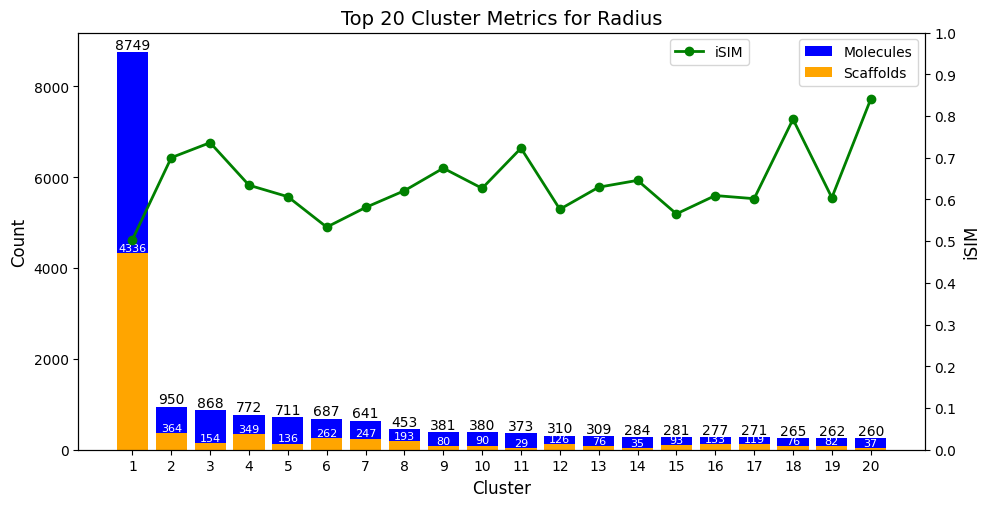

In [7]:
plotting_utils.save_metrics_to_csv(brc_radius, fps, smiles, method=method)
plotting_utils.init_plot(method)

We can see in the largest cluster of the tree we have a much larger number of molecules and number of unique scaffolds, while also have a much lower iSIM value. This is a problem with original BitBIRCH, where this cluster is too large and possesses noise. 

We can also represent the general size of the clusters using a t-SNE plot, colored by the cluster label (cluster 1 through 20). 

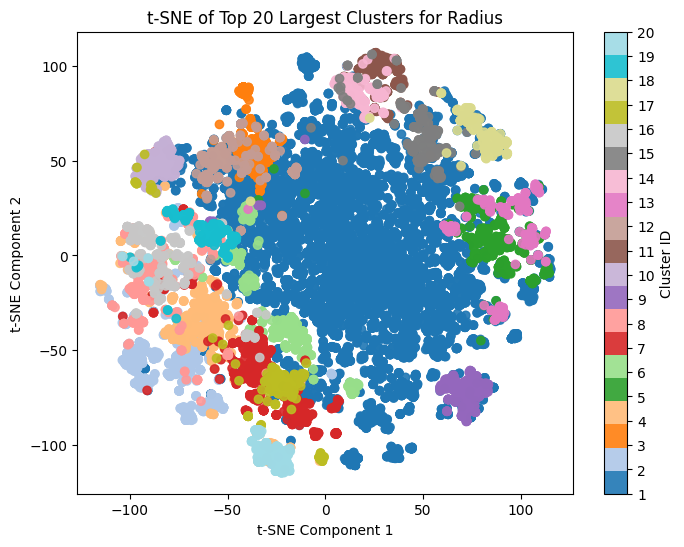

In [8]:
plotting_utils.tsne_plot(brc_radius, fps, method)

### Diameter

Now we will simply change the merge criteria from **radius** to **diameter**.

In [13]:
def diameter(fps):
    bb.set_merge('diameter')
    brc = bb.BitBirch(branching_factor=branching_factor, threshold=threshold)
    brc.fit(fps)
    return brc

In [14]:
brc_diameter = diameter(fps)
method = 'diameter'

Saved cluster metrics for diameter to data/diameter_cluster_metrics.csv


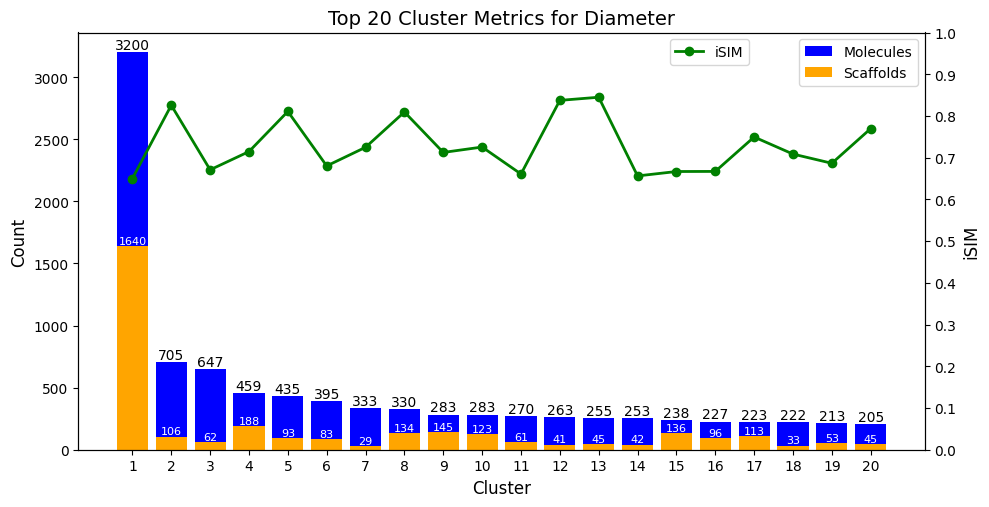

In [12]:
plotting_utils.save_metrics_to_csv(brc_diameter, fps, smiles, method=method)
plotting_utils.init_plot(method)

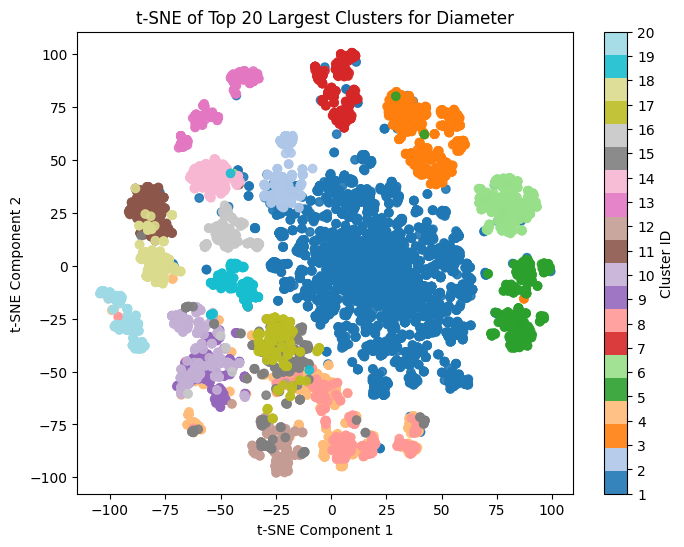

In [13]:
plotting_utils.tsne_plot(brc_diameter, fps, method)

With simply changing to **diameter** merge criteria, not only do the number of molecules and number of scaffolds in the largest cluster greatly reduce, the iSIM and separation of the clusters increases on average across the top 20 clusters. 

While these improvements are very promising, we aren't seeing as much uniformity across the clusters as we would like. How can we further improve upon the cluster quality? 

Also, due to the improvements we are seeing, we will use **diameter** merge criteria for the rest of the following methods. 

### Diameter with Pruning

We will now add the **prune** functionality to our clustering method. This function takes the largest cluster in the tree and reclusters the molecules within this cluster, redistributing them throughout the tree. 

Note that when calling the **fit** function, you now must set the **singly** property to **False**. This allows for the building of a doubly-linked tree, and is required for pruning. 

In [14]:
def diameter_prune(fps):
    bb.set_merge('diameter')
    brc = bb.BitBirch(branching_factor=branching_factor, threshold=threshold)
    brc.fit(fps, singly=False)
    brc.prune(fps)
    return brc

In [15]:
brc_diam_prune = diameter_prune(fps)
method = 'diameter_prune'
title = 'Diameter + Prune'

Saved cluster metrics for diameter_prune to data/diameter_prune_cluster_metrics.csv


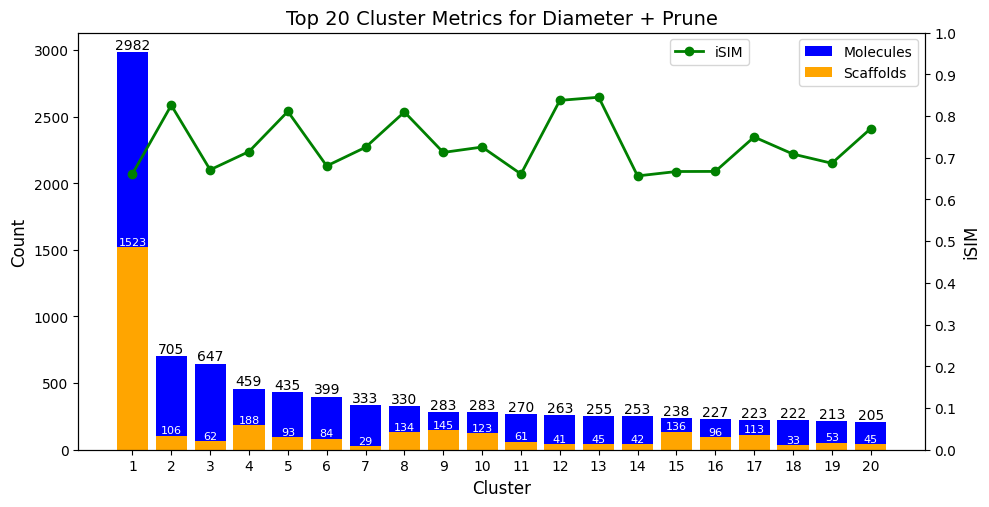

In [16]:
plotting_utils.save_metrics_to_csv(brc_diam_prune, fps, smiles, method=method)
plotting_utils.init_plot(method, title=title)

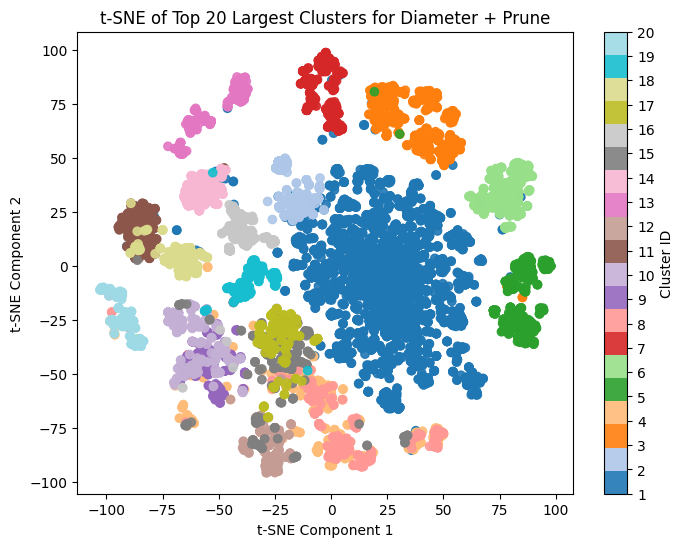

In [17]:
plotting_utils.tsne_plot(brc_diam_prune, fps, method, title=title)

Now we will represent the molecule relocation after pruning the biggest cluster. 

In [20]:
plotting_utils.mol_relocation_plots(brc_diameter, brc_diam_prune, title="Molecule relocation: Diameter vs Diameter + Prune", top_n=20)

With just adding **prune** we see that in some places the results slightly improve, however they are comparable to that when only **diameter** merge criteria is called. Plus only very few molecules are added to other clusters, and a big clusters is formed again. 

### Diameter + Prune + Tolerance 

In order to further improve upon the cluster quality, let's incorporate the **tolerance** merge criteria before we **prune** the largest cluster. 

This method ensures that we are not diminishing the cluster quality of an already well formed, "tight" cluster. 

Here we are setting the default tolerance as 0.05, which is the maximum decrease allowed in cluster similarity/quaility when reinserting the molecules. 

Notice we re-set the merge criteria before calling the **prune** function. 

In [21]:
def diameter_prune_tolerance(fps, tol=0.05):
    bb.set_merge('diameter')
    brc = bb.BitBirch(branching_factor=branching_factor, threshold=threshold)
    brc.fit(fps, singly=False)
    bb.set_merge('tolerance', tolerance=tol)
    brc.prune(fps)
    return brc

In [22]:
brc_diam_prune_tol = diameter_prune_tolerance(fps)
method = 'diameter_prune_tolerance'
title = 'Diameter + Prune + Tolerance'

Saved cluster metrics for diameter_prune_tolerance to data/diameter_prune_tolerance_cluster_metrics.csv


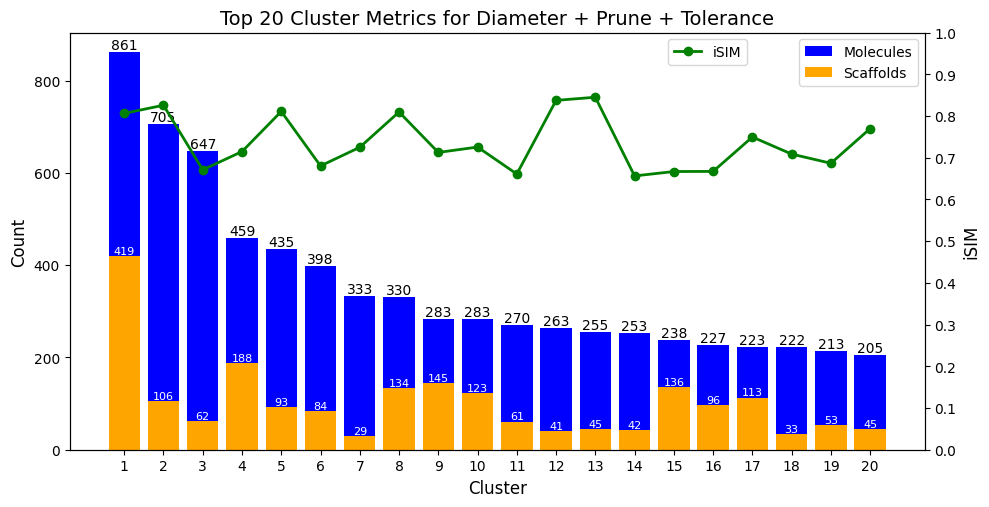

In [24]:
plotting_utils.save_metrics_to_csv(brc_diam_prune_tol, fps, smiles, method=method)
plotting_utils.init_plot(method, title=title)

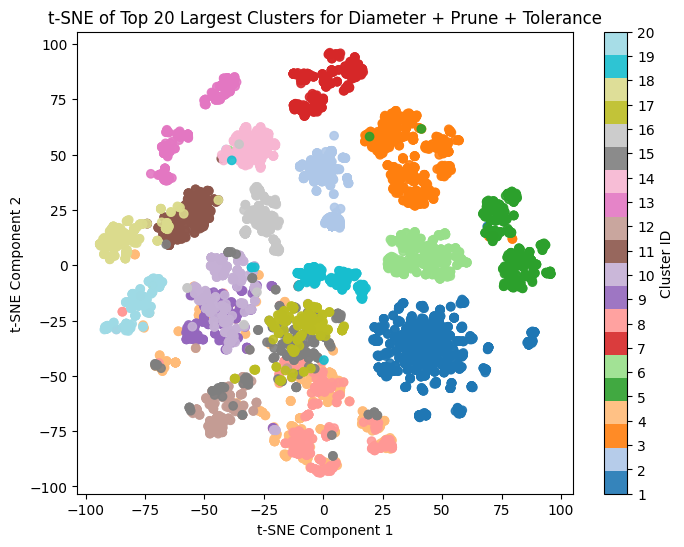

In [25]:
plotting_utils.tsne_plot(brc_diam_prune_tol, fps, method, title=title)

In [26]:
plotting_utils.mol_relocation_plots(brc_diameter, brc_diam_prune_tol, title="Molecule relocation: Diameter vs Diameter + Prune + Tolerance", top_n=20)

The results above highlight the importance of applying the **tolerance** merge criteria before **prune**. We see the cluster quality is enhanced by providing more separation across clusters and more uniformity in size. 

### Diameter + Prune + Reassign

In the new functionality of BitBIRCH we also provide the **reassign** method. This is equivalent to "merging refinement" in the traditional [BIRCH](https://dl.acm.org/doi/abs/10.1145/235968.233324) implementations. 

This method takes the top user-specified largest clusters (here our default is 20), and re-distributes the molecules across these clusters to the closest centroids. 

In [27]:
def diameter_prune_reassign(fps):
    bb.set_merge('diameter')
    brc = bb.BitBirch(branching_factor=branching_factor, threshold=threshold)  
    brc.fit(fps, singly=False)
    brc.prune(fps)
    brc.reassign(fps, top=20)
    return brc

In [28]:
brc_prune_rea = diameter_prune_reassign(fps)
method = 'diameter_prune_reassign'
title = 'Diameter + Prune + Reassign'

Saved cluster metrics for diameter_prune_reassign to data/diameter_prune_reassign_cluster_metrics.csv


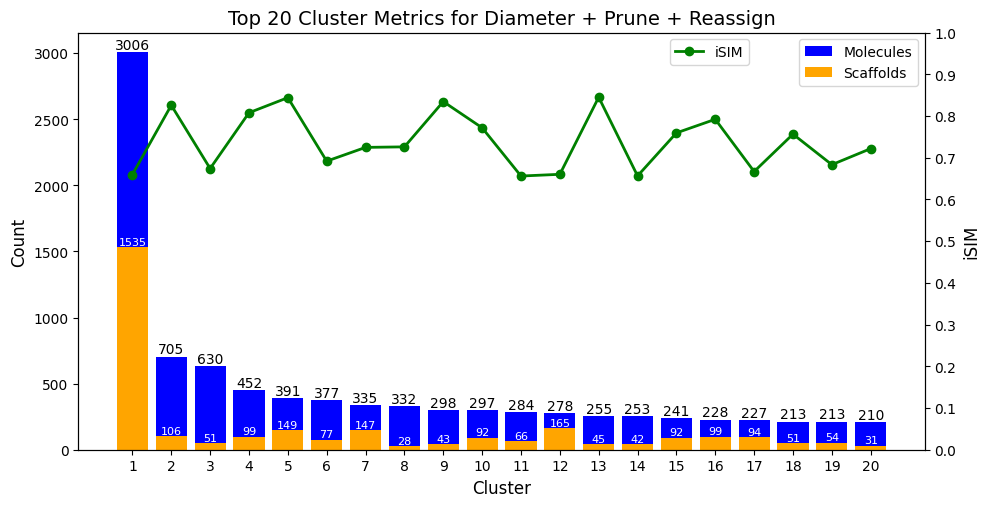

In [29]:
plotting_utils.save_metrics_to_csv(brc_prune_rea, fps, smiles, method=method)
plotting_utils.init_plot(method, title=title)

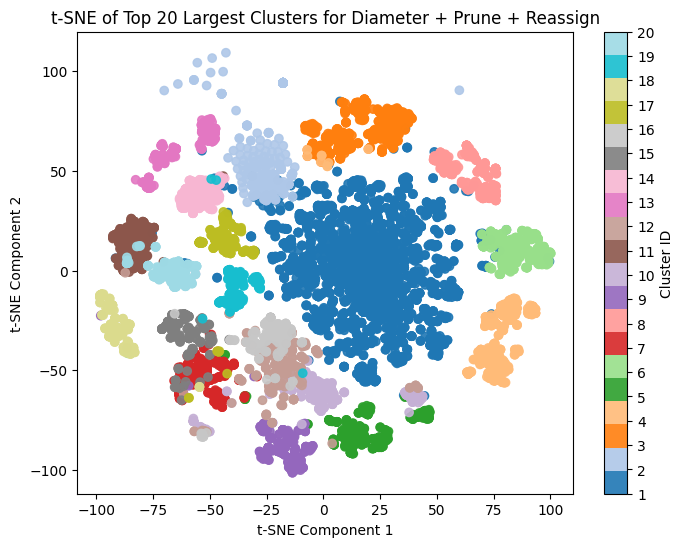

In [30]:
plotting_utils.tsne_plot(brc_prune_rea, fps, method, title=title)

In [32]:
plotting_utils.mol_relocation_plots(brc_diam_prune, brc_prune_rea, title="Molecule relocation: Diameter + Prune vs Diameter + Prune + Reassign", top_n=20)

### Diameter + Prune + Tolerance + Reassign

We will combine all available methods: **diameter, prune, tolerance,** and **reassign**. 

In [33]:
def diameter_prune_tolerance_reassign(fps, tol=0.05):
    bb.set_merge('diameter')
    brc = bb.BitBirch(branching_factor=branching_factor, threshold=threshold)
    brc.fit(fps, singly=False)
    bb.set_merge('tolerance', tolerance=tol)
    brc.prune(fps)
    brc.reassign(fps)
    return brc

In [34]:
brc_prune_tol_rea = diameter_prune_tolerance_reassign(fps)
method = 'diameter_prune_tolerance_reassign'
title = 'Diameter + Prune + Tolerance + Reassign'

Saved cluster metrics for diameter_prune_tolerance_reassign to data/diameter_prune_tolerance_reassign_cluster_metrics.csv


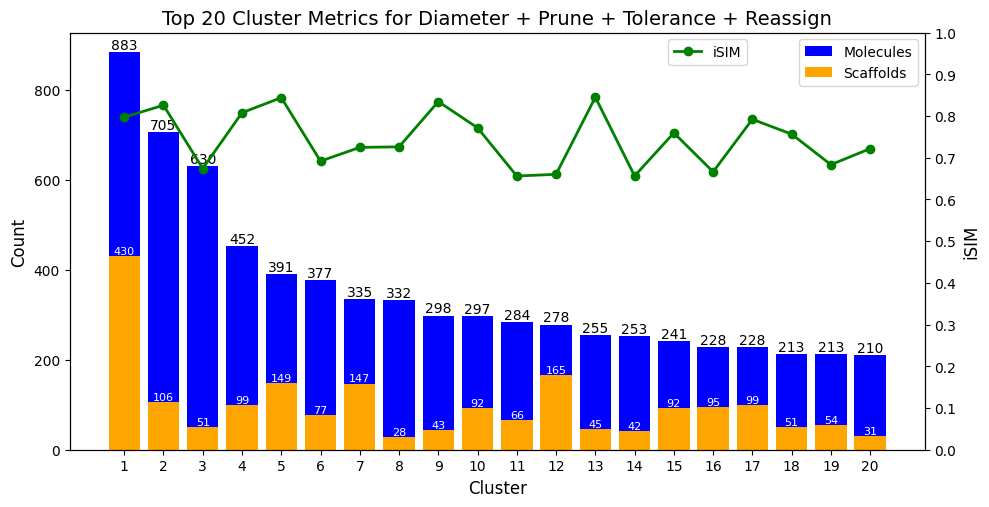

In [36]:
plotting_utils.save_metrics_to_csv(brc_prune_tol_rea, fps, smiles, method=method)
plotting_utils.init_plot(method, title=title)

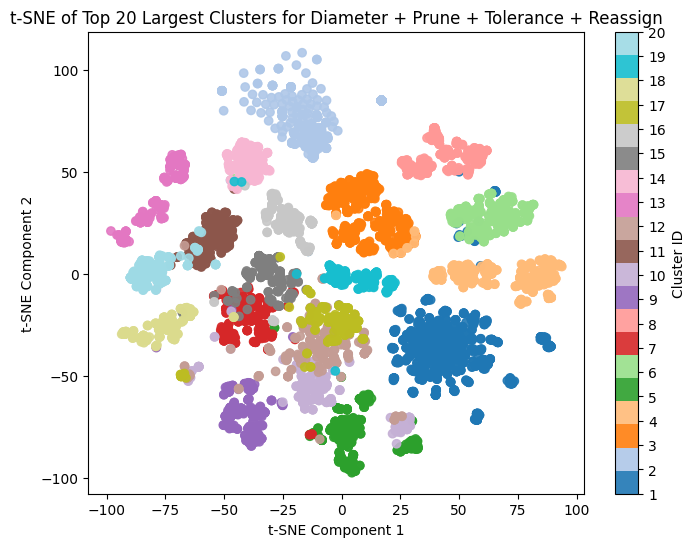

In [37]:
plotting_utils.tsne_plot(brc_prune_tol_rea, fps, method, title=title)

In [38]:
plotting_utils.mol_relocation_plots(brc_diam_prune_tol, brc_prune_tol_rea, title="Molecule relocation: Diameter + Prune + Tolerance vs Diameter + Prune + Tolerance + Reassign", top_n=20)

### BFs reclustering

In this final strategy, we will do diameter clustering with a threshold of 0.65.
Then we will gather the BitFeatures from the generated clusters. We will separate the molecules in the largest inclusters into individual subclusters. We then recluster the initial generated clusters and the new subclusters from the largest one, we can tune the threshold to 0.70 for this tree, but now we will use tolerance = 0.

In [ ]:
def BFs_reclustering(fps, init_threshold = 0.65, second_threshold = 0.7, second_tolerance = 0.0):
    # Do the diameter clustering
    bb.set_merge('diameter')
    brc = bb.BitBirch(branching_factor=branching_factor, threshold=init_threshold)
    brc.fit(fps, singly=True)

    # Extract the BFs for the second clustering
    BFs, big = brc.prepare_data_BFs(fps)

    # Do the second clustering
    bb.set_merge('tolerance', tolerance=second_tolerance)
    brc = bb.BitBirch(branching_factor=branching_factor, threshold=second_threshold)
    brc.fit_BFs(BFs) # Note that we fit the BFs, not the fps
    brc.fit_BFs(big) # Fit the big cluster as well but in individual BFs

    return brc


In [10]:
brc_bfs = BFs_reclustering(fps)
method = 'BFs reclustering'

Saved cluster metrics for BFs reclustering to data/BFs reclustering_cluster_metrics.csv


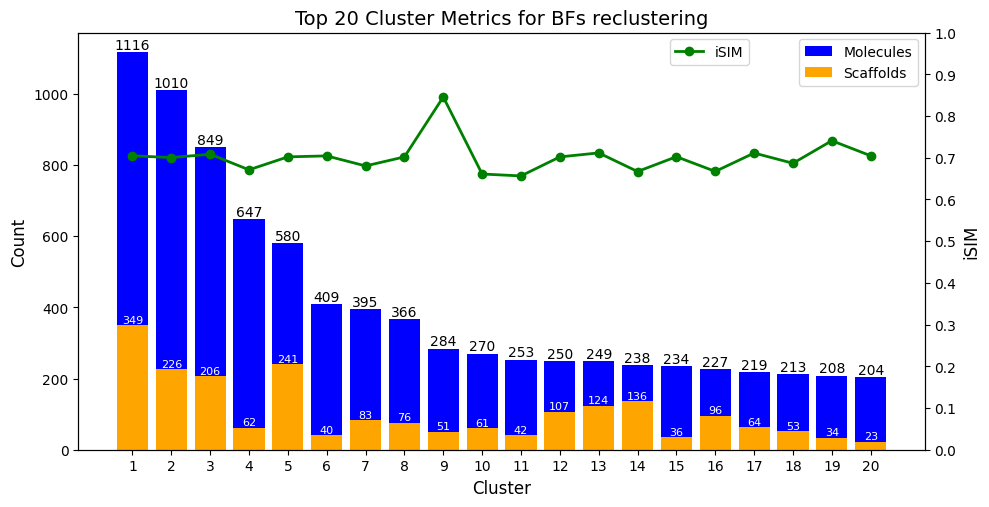

In [11]:
plotting_utils.save_metrics_to_csv(brc_bfs, fps, smiles, method=method)
plotting_utils.init_plot(method)

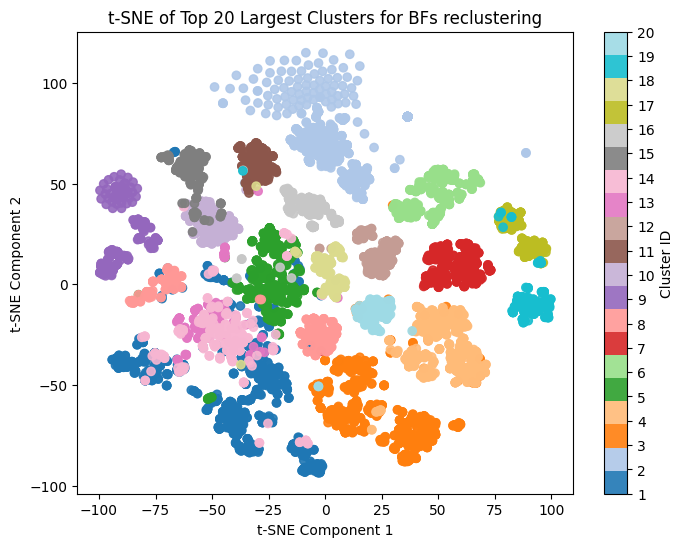

In [48]:
plotting_utils.tsne_plot(brc_bfs, fps, method, title=method)

In [15]:
plotting_utils.mol_relocation_plots(brc_diameter, brc_bfs, title="Molecule relocation: Diameter vs Diameter + BFs", top_n=20)